In [1]:
from typing import Literal
import pandas as pd
#Defining some funtions for later use.

#Lets get the main CO2 and energy data from our world data
def get_merged_datasets(how: Literal['inner', 'left', 'right', 'outer', 'cross'] = 'inner'):
    """
    Get CO2 and energy datasets and merge them.

    Parameters ---------- :param how{‘left’, ‘right’, ‘outer’, ‘inner’, ‘cross’}, default ‘inner’ Type of merge to be
    performed. left: use only keys from left frame, similar to a SQL left outer join; preserve key order. right: use
    only keys from right frame, similar to a SQL right outer join; preserve key order. outer: use union of keys from
    both frames, similar to a SQL full outer join; sort keys lexicographically. inner: use intersection of keys from
    both frames, similar to a SQL inner join; preserve the order of the left keys. cross: creates the cartesian
    product from both frames, preserves the order of the left keys.

    """
    C02_df = pd.read_csv('https://nyc3.digitaloceanspaces.com/owid-public/data/co2/owid-co2-data.csv')
    energy_df = pd.read_csv('https://nyc3.digitaloceanspaces.com/owid-public/data/energy/owid-energy-data.csv')
    to_merge_on = ['year', 'iso_code', 'country']
    C02_df.dropna(subset=to_merge_on, inplace=True)
    energy_df.dropna(subset=to_merge_on, inplace=True)
    cols_to_use = energy_df.columns.difference(C02_df.columns).tolist() + to_merge_on
    csv_data = C02_df.merge(energy_df[cols_to_use], how=how, on=to_merge_on)
    csv_data.dropna(subset=['gdp', 'co2'], inplace=True)
    csv_data.query('year >= 2000', inplace=True)

    return get_extra_features(csv_data, to_merge_on)

#Lets get some other data sources that might prove to inform co2 labels so don't have data from just one place.
def get_extra_features(df: pd.DataFrame, to_merge_on):
    """
    Adds land-use, median age, and population data per country and per year to the main dataset.
    @param df: main data frame to add other pipeline on
    @param to_merge_on: columns to merge data set on
    """
    how = 'left'
    rename_dict = {'Entity': 'country', 'Year': 'year', 'Code': 'iso_code'}

    land_use_df = pd.read_csv(
        "https://dataset-ml-project.s3.us-east-2.amazonaws.com/land-use.csv")  # source: https://ourworldindata.org
    # /land-use
    land_use_df.rename(columns=rename_dict, inplace=True)
    # :DataFrame specifies what object type gets returned
    merged_df: pd.DataFrame = pd.merge(df, land_use_df, on=to_merge_on, how=how, copy=False)

    median_age_df = pd.read_csv(
        "https://dataset-ml-project.s3.us-east-2.amazonaws.com/median-age.csv")  # source: https://ourworldindata.org
    # /grapher/median-age
    median_age_df.rename(columns=rename_dict, inplace=True)
    median_age_df.drop(columns='Median age - Sex: all - Age: all - Variant: medium', inplace=True)
    median_age_df.rename(columns={'Median age - Sex: all - Age: all - Variant: estimates': 'median_age'}, inplace=True)
    median_age_df.dropna(subset='median_age', inplace=True)

    merged_df = pd.merge(merged_df, median_age_df, on=to_merge_on, how=how, copy=False)

    military_expenditure_df = pd.read_csv("https://dataset-ml-project.s3.us-east-2.amazonaws.com"
                                          "/military-expenditure-share-gdp.csv")
    # https://ourworldindata.org/grapher/military-expenditure-share-gdp
    military_expenditure_df.rename(columns=rename_dict, inplace=True)
    merged_df = pd.merge(merged_df, military_expenditure_df, on=to_merge_on, how=how, copy=False)

    rename_dict = {'Country Name': 'country', 'Time': 'year', 'Country Code': 'iso_code'}
    demographics_df = pd.read_csv("https://dataset-ml-project.s3.us-east-2.amazonaws.com/Demographics_WDI.csv")
    # source: https://databank.worldbank.org/reports.aspx?source=world-development-indicators
    demographics_df.rename(columns=rename_dict, inplace=True)
    demographics_df.drop(columns='Time Code', inplace=True)

    merged_df = pd.merge(merged_df, demographics_df, on=to_merge_on, how=how, copy=False)
    import_export_df = pd.read_csv("https://dataset-ml-project.s3.us-east-2.amazonaws.com"
                                   "/Imports_exports_from_WDI_Data.csv")
    # source: https://databank.worldbank.org/reports.aspx?source=world-development-indicators

    import_export_df.rename(columns=rename_dict, inplace=True)
    import_export_df.drop(columns=['Time Code'], inplace=True)

    merged_df = pd.merge(merged_df, import_export_df, on=to_merge_on, how=how, copy=False)

    columns = merged_df.columns
    new_columns = [x.lower().replace(" ", "_") for x in columns]
    for i in range(0, len(columns)):
        merged_df.rename(columns={columns[i]: new_columns[i]}, inplace=True)

    merged_df.dropna(subset=['co2'], inplace=True)
    remove_elipses(merged_df)
    return merged_df


def remove_elipses(df):
    cols = [i for i in df.columns if i not in ["country", "iso_code"]]
    for col in cols:
        df.drop(index=df[df[col] == '..'].index, inplace=True)
        df[col] = pd.to_numeric(df[col])

In [2]:
# get merged dataframe
dataframe = get_merged_datasets()
# Remove feature we do not want to use.
dataframe.drop(columns=['year','country','iso_code'], inplace=True)

In [3]:
#Lets use linear regression, decision tree or random forest to look at feature importance.
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def get_feature_importance(x_train, y_train, feature_list,
                           type : Literal["Linear", "RandomForest", "Tree"] = "Linear",
                           random_state=42):
    if type == "Linear":
        model = LinearRegression()
        model.fit(x_train, y_train)
        feature_importance_data = pd.DataFrame(model.coef_, index=feature_list, columns=["Importance"])
        feature_importance_data.sort_values(by='Importance', ascending=False, inplace=True)
        return feature_importance_data
    elif type == "RandomForest":
        model = RandomForestRegressor(random_state=random_state)
    else:
        model = DecisionTreeRegressor(random_state=random_state)

    model.fit(x_train, y_train)
    feature_importance_data = pd.DataFrame(model.feature_importances_, index=feature_list, columns=["Importance"])
    feature_importance_data.sort_values(by='Importance', ascending=False, inplace=True)

    return feature_importance_data

In [4]:
# lets define a simple pipeline function so comprehensive use.

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

def is_data_leak(s, to_exclude):
    for data_leak in to_exclude:
        if data_leak in s:
            return True
    return False


def get_features_no_data_leaks(df=dataframe):
    # we want to limit our feature set to columns without any data leaks, since in real prediction we wouldn't know
    # those values.
    data_leak_list = ["co2", "ghg", "greenhouse_gas", "change"]
    possible_data_leak_list = ["nitrous_oxide", "methane", "ch4", "n2o"]
    to_exclude = data_leak_list + possible_data_leak_list

    features_list = []
    for x in df.columns:
        is_leak = is_data_leak(x, to_exclude)
        if not is_leak:
            features_list.append(x)

    return features_list


def combine_population_gendered_features(df=dataframe):
    features = df.columns
    fem_features = []
    male_features = []

    for feature in features:
        if 'male' in feature:
            if 'female' in feature:
                fem_features.append(feature)
            else:
                male_features.append(feature)

    fem_child = []
    fem_work_age = []
    fem_retired = []
    male_child = []
    male_work_age = []
    male_retired = []

    children = ['0-4', '5-9', '10-14']
    retired = ['65']
    for (feature_f, feature_m) in zip(fem_features, male_features):
        if any(x in feature_f for x in children):
            fem_child.append(feature_f)
        elif any(x in feature_f for x in retired):
            fem_retired.append(feature_f)
        else:
            fem_work_age.append(feature_f)

        if any(x in feature_m for x in children):
            male_child.append(feature_m)
        elif any(x in feature_m for x in retired):
            male_retired.append(feature_m)
        else:
            male_work_age.append(feature_m)

    df['female_children_by_percent'] = df[fem_child].sum(axis=1)
    df['female_working_age_by_percent'] = df[fem_work_age].sum(axis=1)
    df['female_retired_by_percent'] = df[fem_retired].sum(axis=1)
    df['male_children_by_percent'] = df[male_child].sum(axis=1)
    df['male_working_age_by_percent'] = df[male_work_age].sum(axis=1)
    df['male_retired_by_percent'] = df[male_retired].sum(axis=1)
    df.drop(columns=fem_features, inplace=True)
    df.drop(columns=male_features, inplace=True)
    return


def drop_repeat_fuel_data(df=dataframe):
    drop_list = ['_per_', 'electricity', '_share_']
    for feature in df.columns:
        if any(item in feature for item in drop_list):
            df.drop(columns=feature, inplace=True)


def pipeline(df=dataframe, test_size=0.2, random_state=42):
    data_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")), ('std_scalar', StandardScaler())])
    combine_population_gendered_features(df)
    drop_repeat_fuel_data(df)
    features_list = get_features_no_data_leaks(df)
    x = df[features_list]
    y = df['co2']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    data_pipeline.fit(x_train)
    x_train = data_pipeline.transform(x_train)
    x_test = data_pipeline.transform(x_test)
    return pd.DataFrame(x_train, columns=features_list), pd.DataFrame(x_test, columns=features_list), y_train, \
           y_test, features_list

## Transform data and perform test train split

In [5]:
x_train, x_test, y_train, y_test, feature_list = pipeline(dataframe)

C:\Users\karis\AppData\Local\Temp\ipykernel_8368\636673354.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['female_children_by_percent'] = df[fem_child].sum(axis=1)
C:\Users\karis\AppData\Local\Temp\ipykernel_8368\636673354.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['female_working_age_by_percent'] = df[fem_work_age].sum(axis=1)
C:\Users\karis\AppData\Local\Temp\ipykernel_8368\636673354.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

In [6]:
feature_importance_linear = get_feature_importance(x_train, y_train,
                                                   feature_list, type="Linear")
feature_importance_forest = get_feature_importance(x_train, y_train,
                                                   feature_list,type="RandomForest")
feature_importance_tree = get_feature_importance(x_train, y_train,
                                                 feature_list,
                                                 type="Tree")

feature_importance = pd.merge(feature_importance_linear, feature_importance_tree, left_index=True, right_index=True, how='inner',
                              suffixes=("_linear", "_tree"))
feature_importance = pd.merge(feature_importance, feature_importance_forest, left_index=True, right_index=True, how='inner')
feature_importance.rename(columns={'Importance':'Importance_forest'}, inplace=True)

In [7]:
feature_list = sorted(feature_importance.index.to_list())

## Scale feature importance

In [8]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
feature_importance_abs = feature_importance.abs()
scalar.fit(feature_importance_abs)
feature_importance_abs_scaled = scalar.transform(feature_importance_abs)
feature_importance_abs_scaled = pd.DataFrame(feature_importance_abs_scaled,
                                             index=feature_importance_abs.index,
                                             columns=feature_importance_abs.columns)
feature_importance_abs_scaled

,Importance_linear,Importance_tree,Importance_forest
male_working_age_by_percent,1.000000e+00,2.004366e-05,0.000554
male_children_by_percent,2.062013e-01,0.000000e+00,0.000701
male_retired_by_percent,1.979461e-01,1.769313e-03,0.000104
primary_energy_consumption,7.896244e-11,1.000000e+00,1.000000
renewables_consumption,2.206411e-11,3.639224e-05,0.003080
coal_consumption,1.856508e-11,2.780284e-04,0.036140
gdp,7.408170e-12,2.125312e-05,0.070460
coal_production,5.140126e-12,6.573316e-02,0.176341
gas_consumption,2.503262e-12,3.817891e-06,0.000000
cropland_area_in_hectares,2.343860e-12,4.097494e-06,0.000331


## Choosing feature importance by scaled abs value

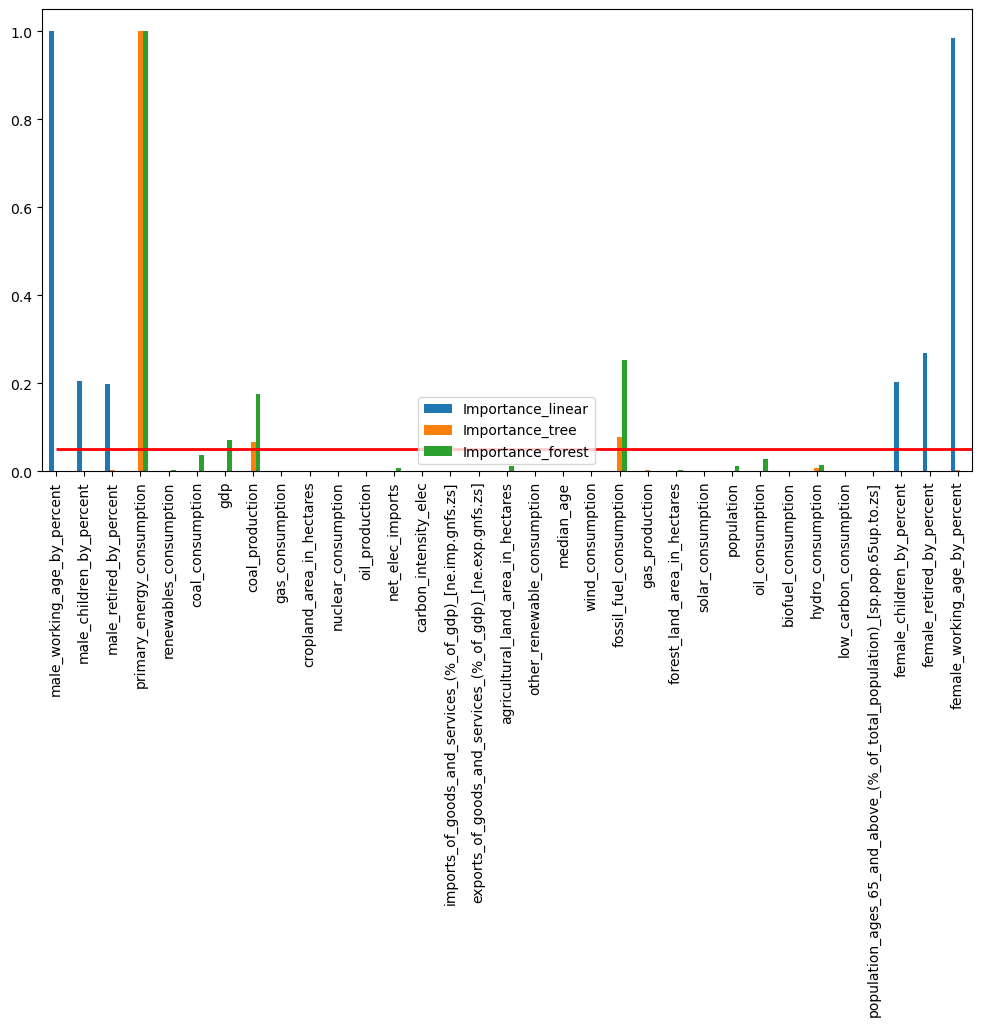

In [9]:
import matplotlib.pyplot as plt
# Set cut off value
suggested_cut_off = 0.05

plot = feature_importance_abs_scaled.plot(kind='bar', figsize=(12,6))
plot.hlines(suggested_cut_off,linewidth=2, xmin=0, xmax=len(feature_list), color='r')
plt.savefig('feature_selection.png', bbox_inches = 'tight')

Inspect cutoff Value in saved fig. This seems reasonable.

### Get set of Selected features

In [10]:
linear_top = feature_importance_abs_scaled.index[feature_importance_abs_scaled.Importance_linear>=suggested_cut_off].tolist()
tree_top = feature_importance_abs_scaled.index[feature_importance_abs_scaled.Importance_tree>=suggested_cut_off].tolist()
forest_top = feature_importance_abs_scaled.index[feature_importance_abs_scaled.Importance_forest>=suggested_cut_off].tolist()
top_features = linear_top+tree_top+forest_top
top_features = set(top_features)
len(top_features)

10

In [11]:
#defining adjusted r2 score function for metrics calculation for the models
def adjusted_r2(r2_score, sample_size, num_features):
    return 1 - (1 - r2_score) * (sample_size - 1) / (sample_size - num_features - 1)

  ##

In [12]:
from sklearn.linear_model import  Lasso, Ridge

linear_model = LinearRegression()
lasso_model = Lasso(random_state=42)
ridge_model = Ridge(random_state=42)
dec_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)
models = [linear_model, lasso_model, ridge_model, dec_tree_model, random_forest_model]
x_train = x_train[list(top_features)]
x_test = x_test[list(top_features)]
for m in models:
    m.fit(x_train, y_train)

In [13]:
from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_error
training_predictions = [m.predict(x_train) for m in models]
mean_sq_errors = [mean_squared_error(y_train, y) for y in training_predictions]
r2_scores = [r2_score(y_train, y) for y in training_predictions]
adj_r2_scores = [adjusted_r2(score, len(x_train),len(x_train.columns)) for score in r2_scores]
mean_absolute_errors = [mean_absolute_error(y_train, y) for y in training_predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}:, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Error: {mean_absolute_errors[i]}") for i, model in enumerate(models)]

Train data scores
 LinearRegression:, Adjusted R2 score: 0.9957112170742162, Mean absolute Error: 26.942196884887597
 Lasso:, Adjusted R2 score: 0.9956139541674461, Mean absolute Error: 26.52040066735131
 Ridge:, Adjusted R2 score: 0.9957079673169543, Mean absolute Error: 27.13293288070532
 DecisionTreeRegressor:, Adjusted R2 score: 1.0, Mean absolute Error: 7.041583665698667e-20
 RandomForestRegressor:, Adjusted R2 score: 0.9996683991874583, Mean absolute Error: 2.7338715179703796


[None, None, None, None, None]

In [14]:

predictions = [m.predict(x_test) for m in models]
mean_sq_errors = [mean_squared_error(y_test, y) for y in predictions]
r2_scores = [r2_score(y_test, y) for y in predictions]
adj_r2_scores = [adjusted_r2(score, len(x_test),len(x_test.columns)) for score in r2_scores]
mean_absolute_errors = [mean_absolute_error(y_test, y) for y in predictions]
print("Test data scores")
[print(f" {model.__class__.__name__}:, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Error: {mean_absolute_errors[i]}") for i, model in enumerate(models)]

Test data scores
 LinearRegression:, Adjusted R2 score: 0.9946807629317872, Mean absolute Error: 31.898699637339934
 Lasso:, Adjusted R2 score: 0.994578767132504, Mean absolute Error: 31.017132395714498
 Ridge:, Adjusted R2 score: 0.9946497885469391, Mean absolute Error: 32.03801709366329
 DecisionTreeRegressor:, Adjusted R2 score: 0.9757015660939559, Mean absolute Error: 17.62846452702702
 RandomForestRegressor:, Adjusted R2 score: 0.9967471616906808, Mean absolute Error: 10.39677346283786


[None, None, None, None, None]

In [15]:
from sklearn.model_selection import GridSearchCV
import os
best_hyper_params_csv = 'best_hyper_params.csv'

best_params_records = []
grid = {'fit_intercept':[True, False]}
CV_lin = GridSearchCV(estimator=linear_model, param_grid=grid, cv=5, scoring='neg_median_absolute_error', n_jobs=-1)
CV_lin.fit(x_train, y_train)
best_params_records.append({'model': 'linear regression', **CV_lin.best_params_})

grid = {'alpha': [0.1,2], 'max_iter': [100, 2000], 'tol': [0.01, 0.0001]}
CV_lasso = GridSearchCV(estimator=lasso_model, param_grid=grid, cv=5, scoring='neg_median_absolute_error', n_jobs=-1)
CV_lasso.fit(x_train, y_train)
best_params_records.append({'model': 'lesso', **CV_lasso.best_params_})
CV_ridge = GridSearchCV(estimator=ridge_model, param_grid=grid, cv=5, scoring='neg_median_absolute_error', n_jobs=-1)
CV_ridge.fit(x_train, y_train)
best_params_records.append({'model': 'ridge', **CV_ridge.best_params_})
grid = {'n_estimators': [100,200,500,1000],
               'max_features': ['sqrt', 'log2'],
               'max_depth': [10,20,50,100],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

CV_forest = GridSearchCV(estimator=random_forest_model, param_grid=grid, cv=5, scoring='neg_median_absolute_error', n_jobs=-1)
CV_forest.fit(x_train, y_train)
best_params_records.append({'model': 'Forest', **CV_forest.best_params_})
grid = {'max_features': ['sqrt', 'log2'],
               'max_depth': [10,20,50,100],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

CV_tree = GridSearchCV(estimator=dec_tree_model, param_grid=grid, cv=5, scoring='neg_median_absolute_error', n_jobs=-1)
CV_tree.fit(x_train, y_train)
best_params_records.append({'model': 'Tree', **CV_tree.best_params_})
best_hyper_params = pd.DataFrame.from_records(best_params_records)
best_hyper_params.to_csv("best_hyper_params.csv", index=False)

C:\ProgramData\anaconda3\envs\co2-emission-ML\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.571e+06, tolerance: 1.480e+05
  model = cd_fast.enet_coordinate_descent(


## Ensmble Modelling via Voting Regressor

In [16]:
from sklearn.ensemble import VotingRegressor

voting_model = VotingRegressor(estimators=[("lasso", lasso_model), ("ridge", ridge_model), ("linear", linear_model), ("dec_tree", dec_tree_model)], n_jobs=-1, verbose=True)
voting_model.fit(x_train, y_train)

VotingRegressor(estimators=[('lasso', Lasso(random_state=42)),
                            ('ridge', Ridge(random_state=42)),
                            ('linear', LinearRegression()),
                            ('dec_tree',
                             DecisionTreeRegressor(random_state=42))],
                n_jobs=-1, verbose=True)

In [17]:
random_forest_model = CV_forest.best_estimator_

In [18]:
models = [ CV_lasso.best_estimator_, CV_ridge.best_estimator_, CV_lin.best_estimator_, CV_tree.best_estimator_, voting_model, random_forest_model,]
training_predictions = [m.predict(x_train) for m in models]
mean_sq_errors = [mean_squared_error(y_train, y) for y in training_predictions]
r2_scores = [r2_score(y_train, y) for y in training_predictions]
adj_r2_scores = [adjusted_r2(score, len(x_train),len(x_train.columns)) for score in r2_scores]
mean_absolute_errors = [mean_absolute_error(y_train, y) for y in training_predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}: Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Error: {mean_absolute_errors[i]}") for i, model in enumerate(models)]

Train data scores
 Lasso: Adjusted R2 score: 0.9956656244553462, Mean absolute Error: 26.224178037213875
 Ridge: Adjusted R2 score: 0.9957111856176697, Mean absolute Error: 26.95704409385123
 LinearRegression: Adjusted R2 score: 0.9957112170742162, Mean absolute Error: 26.942196884887597
 DecisionTreeRegressor: Adjusted R2 score: 1.0, Mean absolute Error: 0.0
 VotingRegressor: Adjusted R2 score: 0.9975811744214681, Mean absolute Error: 20.014841812211973
 RandomForestRegressor: Adjusted R2 score: 0.9999999902759867, Mean absolute Error: 0.038755083067252984


[None, None, None, None, None, None]

In [19]:
predictions = [m.predict(x_test) for m in models]
mean_sq_errors = [mean_squared_error(y_test, y) for y in predictions]
r2_scores = [r2_score(y_test, y) for y in predictions]
adj_r2_scores = [adjusted_r2(score, len(x_test),len(x_test.columns)) for score in r2_scores]
mean_absolute_errors = [mean_absolute_error(y_test, y) for y in predictions]
print("Test data scores")
[print(f" {model.__class__.__name__}: Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Error: {mean_absolute_errors[i]}") for i, model in enumerate(models)]

Test data scores
 Lasso: Adjusted R2 score: 0.9947646498449821, Mean absolute Error: 30.975419133203864
 Ridge: Adjusted R2 score: 0.9946778296997736, Mean absolute Error: 31.90890325716015
 LinearRegression: Adjusted R2 score: 0.9946807629317872, Mean absolute Error: 31.898699637339934
 DecisionTreeRegressor: Adjusted R2 score: 0.9976630906797198, Mean absolute Error: 11.844675675675678
 VotingRegressor: Adjusted R2 score: 0.9957981863509318, Mean absolute Error: 26.103128691878954
 RandomForestRegressor: Adjusted R2 score: 0.9943461640986894, Mean absolute Error: 10.068485184125144


[None, None, None, None, None, None]

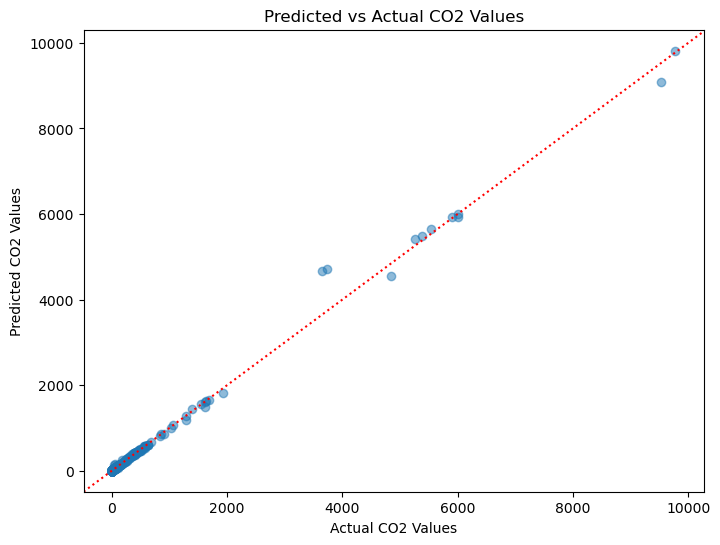

In [20]:
import matplotlib.pyplot as plt

# Plotting predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions[5], alpha=0.5)
plt.xlabel('Actual CO2 Values')
plt.ylabel('Predicted CO2 Values')
plt.title('Predicted vs Actual CO2 Values')
plt.axline((0, 0), slope=1, linestyle=':', color="r")
plt.show()

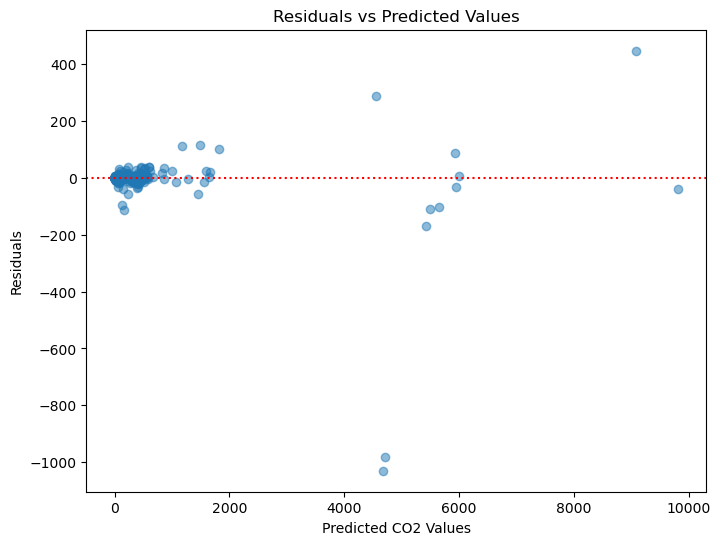

In [21]:
# Assuming you have your actual and predicted values as follows:
actual_values = y_test
predicted_values = predictions[5]

# Calculate residuals
residuals = actual_values - predicted_values

# Plotting the residuals
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted CO2 Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle=':')  # Adds a horizontal line at zero
plt.show()